# IndoBERT FP32 Fine-tuning Pipeline - 3-Label Classification

This notebook fine-tunes the IndoBERT-base model on Indonesian sentiment analysis with 3 labels: **positive, neutral, negative**.

**Dataset:**
SMSA (Sentiment Analysis) from IndoNLU benchmark

**Labels:**
- Positive (0)
- Neutral (1)
- Negative (2)

**Pipeline:**
1. Load SMSA dataset (train/val/test TSV files)
2. Map text labels to numeric values
3. Tokenize using IndoBERT tokenizer
4. Fine-tune model with 3-label classification
5. Evaluate on test set
6. Save fine-tuned model

**Hyperparameters:**
- Learning rate: 2e-5
- Batch size: 16
- Epochs: 3
- Precision: FP32
- Optimizer: AdamW
- Max sequence length: 128

In [1]:
# !pip install --upgrade numpy
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !pip install transformers datasets accelerate
# !pip install scikit-learn
# !pip install Sastrawati

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from collections import Counter

import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re

## Load Tokenizer

In [3]:
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p2")
print(f"Tokenizer loaded: {tokenizer.__class__.__name__}")

c:\Users\bertr\anaconda3\envs\speech_recognition\lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Tokenizer loaded: BertTokenizerFast


## Define Tokenization Function

In [4]:
def tokenize_fn(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

## Load SMSA Dataset

In [ ]:
dataset = load_dataset(
    'csv',
    data_files={
        'train': 'train.tsv',
        'validation': 'valid.tsv',
        'test': 'test.tsv'
    },
    delimiter='\t',
    column_names=['text', 'label']
)

print(f"Train samples: {len(dataset['train']):,}")
print(f"Validation samples: {len(dataset['validation']):,}")
print(f"Test samples: {len(dataset['test']):,}")
print(f"\nColumns: {dataset['train'].column_names}")
print(f"\nSample: {dataset['train'][0]}")
print(f"\nLabel distribution in training set:")

label_counts = Counter(dataset['train']['label'])
for label, count in label_counts.items():
    print(f"  {label}: {count}")

Train samples: 11,000
Validation samples: 1,260
Test samples: 500

Columns: ['text', 'label']

Sample: {'text': 'warung ini dimiliki oleh pengusaha pabrik tahu yang sudah puluhan tahun terkenal membuat tahu putih di bandung . tahu berkualitas , dipadu keahlian memasak , dipadu kretivitas , jadilah warung yang menyajikan menu utama berbahan tahu , ditambah menu umum lain seperti ayam . semuanya selera indonesia . harga cukup terjangkau . jangan lewatkan tahu bletoka nya , tidak kalah dengan yang asli dari tegal !', 'label': 'positive'}

Label distribution in training set:
  positive: 6416
  neutral: 1148
  negative: 3436


## Map Labels to Numeric Values

In [6]:
# label mapping
label2id = {
    'positive': 0,
    'neutral': 1,
    'negative': 2
}
id2label = {
    0: 'positive',
    1: 'neutral',
    2: 'negative'
}

def map_labels(df):
    df['label'] = [label2id[label] for label in df['label']]
    return df

dataset = dataset.map(
    map_labels,
    batched=True,
    desc="Mapping labels to numeric values"
)

print("\nAfter mapping, sample label:", dataset['train'][0]['label'])
print(f"Label type: {type(dataset['train'][0]['label'])}")

Mapping labels to numeric values:   0%|          | 0/11000 [00:00<?, ? examples/s]

Mapping labels to numeric values:   0%|          | 0/1260 [00:00<?, ? examples/s]

Mapping labels to numeric values:   0%|          | 0/500 [00:00<?, ? examples/s]


After mapping, sample label: 0
Label type: <class 'int'>


## Load FP32 IndoBERT Model

In [7]:
model_fp32 = AutoModelForSequenceClassification.from_pretrained(
    "indobenchmark/indobert-base-p2",
    num_labels=3,
    id2label=id2label,
    label2id=label2id,
)

print(f"Model loaded: {model_fp32.__class__.__name__}")
print(f"Number of parameters: {model_fp32.num_parameters():,}")
print(f"Number of labels: {model_fp32.config.num_labels}")
print(f"Label mapping: {model_fp32.config.label2id}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded: BertForSequenceClassification
Number of parameters: 124,443,651
Number of labels: 3
Label mapping: {'positive': 0, 'neutral': 1, 'negative': 2}


## Text Preprocessing

In [8]:
stopword_factory = StopWordRemoverFactory()
indonesian_stopwords = stopword_factory.get_stop_words()

print(f"Loaded {len(indonesian_stopwords)} Indonesian stop words")
print(f"Sample stop words: {list(indonesian_stopwords)[:10]}")

Loaded 126 Indonesian stop words
Sample stop words: ['yang', 'untuk', 'pada', 'ke', 'para', 'namun', 'menurut', 'antara', 'dia', 'dua']


In [9]:
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    
    # convert to lowercase
    text = text.lower()
    
    # remove non-alphabetic characters (keep only letters and spaces)
    text = re.sub(r'[^a-z\s]', '', text)
    
    # remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    # remove stop words
    words = text.split()
    words = [word for word in words if word not in indonesian_stopwords]
    text = ' '.join(words)
    
    return text

sample_text = "Ini adalah contoh kalimat! Apakah preprocessing berfungsi? 123 #test"
print(f"Original: {sample_text}")
print(f"Preprocessed: {preprocess_text(sample_text)}")

Original: Ini adalah contoh kalimat! Apakah preprocessing berfungsi? 123 #test
Preprocessed: contoh kalimat preprocessing berfungsi test


In [ ]:
print("Applying preprocessing to dataset...")
print("Before preprocessing:")
print(f"  Sample text: {dataset['train'][0]['text'][:100]}...")

def preprocess_dataset(examples):
    """Apply preprocessing to a batch of examples"""
    examples['text'] = [preprocess_text(text) for text in examples['text']]
    return examples

dataset = dataset.map(
    preprocess_dataset,
    batched=True,
    desc="Preprocessing text"
)

print("\nAfter preprocessing:")
print(f"  Sample text: {dataset['train'][0]['text'][:100]}...")
print("\nPreprocessing complete!")

Applying preprocessing to dataset...
Before preprocessing:
  Sample text: warung ini dimiliki oleh pengusaha pabrik tahu yang sudah puluhan tahun terkenal membuat tahu putih ...


Preprocessing text:   0%|          | 0/11000 [00:00<?, ? examples/s]

Preprocessing text:   0%|          | 0/1260 [00:00<?, ? examples/s]

Preprocessing text:   0%|          | 0/500 [00:00<?, ? examples/s]


After preprocessing:
  Sample text: warung dimiliki pengusaha pabrik tahu puluhan tahun terkenal membuat tahu putih bandung tahu berkual...

Preprocessing complete!


## Tokenize Dataset

In [11]:
tokenized_dataset = dataset.map(
    tokenize_fn,
    batched=True,
    remove_columns=['text']
)

print("Tokenization complete!")
print(f"Columns after tokenization: {tokenized_dataset['train'].column_names}")
print(f"\nSample tokenized data:")
print(f"  input_ids length: {len(tokenized_dataset['train'][0]['input_ids'])}")
print(f"  attention_mask length: {len(tokenized_dataset['train'][0]['attention_mask'])}")
print(f"  label: {tokenized_dataset['train'][0]['label']}")

Parameter 'function'=<function tokenize_fn at 0x00000227EA21E710> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/11000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1260 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Tokenization complete!
Columns after tokenization: ['label', 'input_ids', 'token_type_ids', 'attention_mask']

Sample tokenized data:
  input_ids length: 128
  attention_mask length: 128
  label: 0


## Define Metrics Function

In [12]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted'
    )
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

## Configure Training Arguments

In [13]:
output_dir = "./results/indobert-fp32-smsa-3label"

training_args = TrainingArguments(
    output_dir=output_dir,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir=f"{output_dir}/logs",
    logging_steps=100,
    report_to="none",
    fp16=False,
    push_to_hub=False
)

print("Training arguments configured:")
print(f"  Output directory: {output_dir}")
print(f"  Learning rate: {training_args.learning_rate}")
print(f"  Batch size: {training_args.per_device_train_batch_size}")
print(f"  Epochs: {training_args.num_train_epochs}")
print(f"  Precision: FP32")
print(f"  Number of labels: 3 (positive, neutral, negative)")

Training arguments configured:
  Output directory: ./results/indobert-fp32-smsa-3label
  Learning rate: 2e-05
  Batch size: 16
  Epochs: 3
  Precision: FP32
  Number of labels: 3 (positive, neutral, negative)


## Initialize Trainer

In [14]:
trainer = Trainer(
    model=model_fp32,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

print("Trainer initialized successfully!")

Trainer initialized successfully!


## Start Fine-tuning

In [15]:
print("Starting training...")
print("="*70)

train_result = trainer.train()

print("\n" + "="*70)
print("Training completed!")
print(f"Training loss: {train_result.training_loss:.4f}")
print(f"Training runtime: {train_result.metrics['train_runtime']:.2f} seconds")
print(f"Training samples/second: {train_result.metrics['train_samples_per_second']:.2f}")

Starting training...


c:\Users\bertr\anaconda3\envs\speech_recognition\lib\site-packages\transformers\optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/2064 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.47, 'learning_rate': 1.9031007751937985e-05, 'epoch': 0.15}
{'loss': 0.3549, 'learning_rate': 1.8062015503875972e-05, 'epoch': 0.29}
{'loss': 0.3013, 'learning_rate': 1.7093023255813955e-05, 'epoch': 0.44}
{'loss': 0.3073, 'learning_rate': 1.612403100775194e-05, 'epoch': 0.58}
{'loss': 0.3111, 'learning_rate': 1.5155038759689924e-05, 'epoch': 0.73}
{'loss': 0.2742, 'learning_rate': 1.4186046511627909e-05, 'epoch': 0.87}


  0%|          | 0/79 [00:00<?, ?it/s]

{'eval_loss': 0.29360947012901306, 'eval_accuracy': 0.8865079365079365, 'eval_precision': 0.8869650031970874, 'eval_recall': 0.8865079365079365, 'eval_f1': 0.886627769425775, 'eval_runtime': 7.7856, 'eval_samples_per_second': 161.837, 'eval_steps_per_second': 10.147, 'epoch': 1.0}
{'loss': 0.2706, 'learning_rate': 1.3217054263565892e-05, 'epoch': 1.02}
{'loss': 0.1643, 'learning_rate': 1.2248062015503876e-05, 'epoch': 1.16}
{'loss': 0.2205, 'learning_rate': 1.1279069767441861e-05, 'epoch': 1.31}
{'loss': 0.163, 'learning_rate': 1.0310077519379846e-05, 'epoch': 1.45}
{'loss': 0.1565, 'learning_rate': 9.34108527131783e-06, 'epoch': 1.6}
{'loss': 0.1786, 'learning_rate': 8.372093023255815e-06, 'epoch': 1.74}
{'loss': 0.1677, 'learning_rate': 7.403100775193799e-06, 'epoch': 1.89}


  0%|          | 0/79 [00:00<?, ?it/s]

{'eval_loss': 0.3225501775741577, 'eval_accuracy': 0.8976190476190476, 'eval_precision': 0.8974980182002625, 'eval_recall': 0.8976190476190476, 'eval_f1': 0.8970329808880547, 'eval_runtime': 7.7165, 'eval_samples_per_second': 163.286, 'eval_steps_per_second': 10.238, 'epoch': 2.0}
{'loss': 0.1519, 'learning_rate': 6.434108527131784e-06, 'epoch': 2.03}
{'loss': 0.1156, 'learning_rate': 5.465116279069767e-06, 'epoch': 2.18}
{'loss': 0.1032, 'learning_rate': 4.4961240310077525e-06, 'epoch': 2.33}
{'loss': 0.0839, 'learning_rate': 3.527131782945737e-06, 'epoch': 2.47}
{'loss': 0.0748, 'learning_rate': 2.558139534883721e-06, 'epoch': 2.62}
{'loss': 0.1243, 'learning_rate': 1.5891472868217056e-06, 'epoch': 2.76}
{'loss': 0.1188, 'learning_rate': 6.201550387596899e-07, 'epoch': 2.91}


  0%|          | 0/79 [00:00<?, ?it/s]

{'eval_loss': 0.4020112156867981, 'eval_accuracy': 0.8984126984126984, 'eval_precision': 0.897773486341577, 'eval_recall': 0.8984126984126984, 'eval_f1': 0.8978473344931935, 'eval_runtime': 8.4593, 'eval_samples_per_second': 148.948, 'eval_steps_per_second': 9.339, 'epoch': 3.0}
{'train_runtime': 787.3074, 'train_samples_per_second': 41.915, 'train_steps_per_second': 2.622, 'train_loss': 0.2017116292502529, 'epoch': 3.0}

Training completed!
Training loss: 0.2017
Training runtime: 787.31 seconds
Training samples/second: 41.91


## Evaluate on Test Set

In [16]:
print("Evaluating on test set...")
test_results = trainer.evaluate(tokenized_dataset['test'])

print("\nTest Set Results:")
print("="*70)
print(f"  Accuracy:  {test_results['eval_accuracy']:.4f}")
print(f"  Precision: {test_results['eval_precision']:.4f}")
print(f"  Recall:    {test_results['eval_recall']:.4f}")
print(f"  F1 Score:  {test_results['eval_f1']:.4f}")
print("="*70)

Evaluating on test set...


  0%|          | 0/32 [00:00<?, ?it/s]


Test Set Results:
  Accuracy:  0.8760
  Precision: 0.8788
  Recall:    0.8760
  F1 Score:  0.8735


  0%|          | 0/32 [00:00<?, ?it/s]

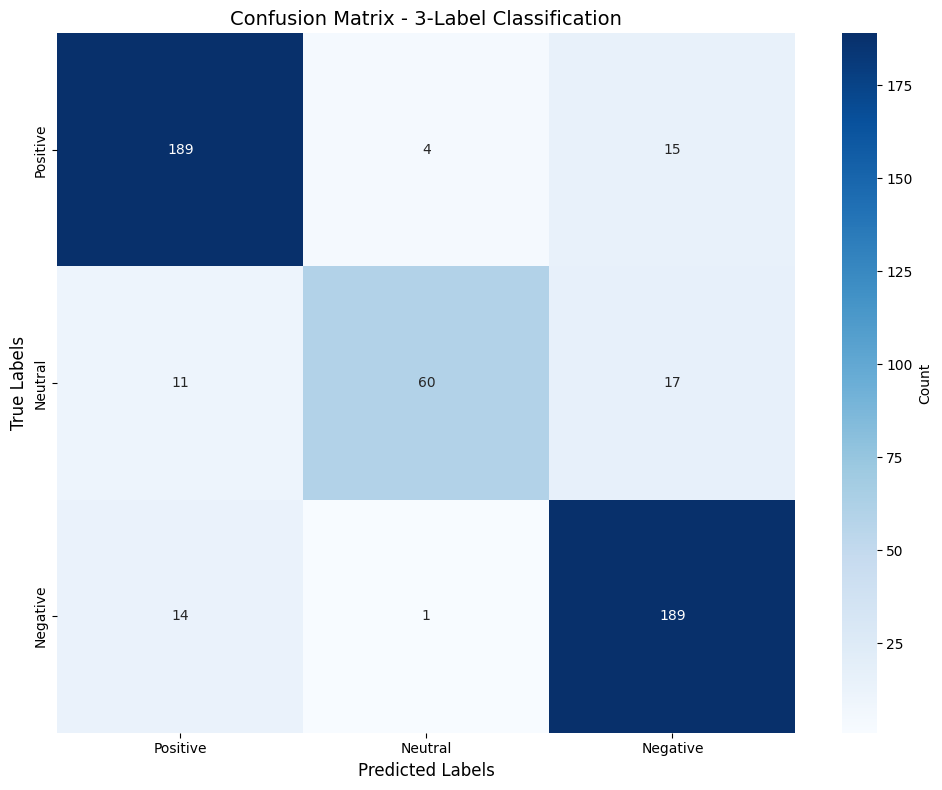


Detailed Classification Report:
              precision    recall  f1-score   support

    Positive       0.88      0.91      0.90       208
     Neutral       0.92      0.68      0.78        88
    Negative       0.86      0.93      0.89       204

    accuracy                           0.88       500
   macro avg       0.89      0.84      0.86       500
weighted avg       0.88      0.88      0.87       500



In [ ]:
predictions_output = trainer.predict(tokenized_dataset['test'])
y_pred = predictions_output.predictions.argmax(-1)
y_true = predictions_output.label_ids
cm = confusion_matrix(y_true, y_pred)

label_names = ['Positive', 'Neutral', 'Negative']

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_names, 
            yticklabels=label_names,
            cbar_kws={'label': 'Count'})
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.title("Confusion Matrix - 3-Label Classification", fontsize=14)
plt.tight_layout()
plt.show()

from sklearn.metrics import classification_report
print("\nDetailed Classification Report:")
print("="*70)
print(classification_report(y_true, y_pred, target_names=label_names))
print("="*70)

## Save Fine-tuned Model

In [18]:
save_path = "./models/indobert-fp32-smsa-3label-finetuned"

trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)

print(f"Model and tokenizer saved to: {save_path}")
print("\nYou can load the model later with:")
print(f"  model = AutoModelForSequenceClassification.from_pretrained('{save_path}')")
print(f"  tokenizer = AutoTokenizer.from_pretrained('{save_path}')")
print(f"\nModel configuration:")
print(f"  - num_labels: 3")
print(f"  - label mapping: {label2id}")

Model and tokenizer saved to: ./models/indobert-fp32-smsa-3label-finetuned

You can load the model later with:
  model = AutoModelForSequenceClassification.from_pretrained('./models/indobert-fp32-smsa-3label-finetuned')
  tokenizer = AutoTokenizer.from_pretrained('./models/indobert-fp32-smsa-3label-finetuned')

Model configuration:
  - num_labels: 3
  - label mapping: {'positive': 0, 'neutral': 1, 'negative': 2}
